<a href="https://colab.research.google.com/github/yaswanthkumargothi/Portfolio/blob/master/cnr_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wind Power forecasting for the day-ahead energy market
by ***Compagnie Nationale du Rhône***


CNR is the French leading producer of exclusively renewable energy (water,wind, sun) and the concessionary of the Rhone river for hydroelectricity production, river navigation and irrigation for agricultural use. This challenge focuses on wind energy production forecast. CNR currently owns around 50 Wind Farms (WF) for a total installed capacity of more than 600 MW. Every day, CNR sells on the energy market its wind energy production for the day ahead. In order to sell the right amount of energy, as well as for legal requirements towards the French Transmission System Operator (TSO) in charge of the electric network stability, CNR needs to know beforehand how much energy the wind farms will produce the day ahead.




##Challenge goals
The goal of this challenge is to predict the energy production of six WF owned by CNR. Each WF production will be individually predicted, using meteorological forecasts as input. Predictions will focus on the day-ahead energy production (hourly production forecasts from day D+1 00h to day D+2 00h).

##Project Outline

1.   Data Understanding
2.   Functions to extract Data
3.   Missing value imputation
4.   Feature Engineering
5.   ML Models
6.   Facebook Prophet
7.   Neural Nets
8.   Conclusion



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
from datetime import datetime


In [ ]:
#!pip install ipympl
#%matplotlib widget

###Data

####Data description
The six WF hourly production data from May the 1st of 2018 to January the 15th of 2019 (8 months and 15 days) is provided. This defines the training dataset, since day-ahead WF hourly production is the prediction target (predictand). Provided hourly WF power production consists in the raw recordings of the DSO (Distribution System Operator), and should therefore be considered as a reference, even if it could contain erroneous or suspect data. The choice is left to competitors to criticize or not this data, using complementary data provided apart.

The test period will run from January the 16^th^ of 2019 to September the 30^rd^ of 2019 (8 months and 15 days). Evaluation will be performed on raw observed hourly WF power production.

For confidentiality purposes, the names of the six considered WF will not appear in the challenge, and we will use generic names instead: WF1, ... , WF6. For similar reasons, locations of the WF will not be provided.

For both training and test periods, predicting variables (predictors) will be given. It consists in hourly forecasted meteorological variables, provided by various Numerical Weather Prediction (NWP) models. NWP models are meteorological models run by several national weather prediction services. For confidentiality reasons, the name of the NWP models will not appear. They will be named with generic names NWP1, ... , NWPn.

We propose to provide also complementary observed data, which could not be used as predicting variables (because these data are not subject to forecasts), but which may help competitors to prepare or criticize WF hourly production data. This consists in hourly wind speeds and wind directions observed at the height of each wind turbine, on each WF. Obviously, complementary data will not be provided for the test period.

In [4]:
path = '/content/drive/My Drive/cnr/Y_train_sl9m6Jh.csv'
y_train=pd.read_csv(path,encoding = "ISO-8859-1",delimiter=',')
path = '/content/drive/My Drive/cnr/X_train_v2.csv'
X_train=pd.read_csv(path,encoding = "ISO-8859-1",delimiter=',')
#pd.set_option('display.max_rows', 1000)
#X_train.isna().sum()
path='/content/drive/My Drive/cnr/X_test_v2.csv'
X_test=pd.read_csv(path,encoding = "ISO-8859-1",delimiter=',')
path= '/content/drive/My Drive/cnr/Y_test_random.csv'
y_test=pd.read_csv(path,encoding = "ISO-8859-1",delimiter=',')
path = '/content/drive/My Drive/cnr/WindFarms_complementary_data.csv'
complementary=pd.read_csv(path,encoding = "ISO-8859-1",delimiter=';')

In [ ]:
pd.set_option('display.max_rows', 1000)
X_train.isnull().sum()

ID                       0
WF                       0
Time                     0
NWP1_00h_D-2_U       17364
NWP1_00h_D-2_V       17364
NWP1_00h_D-2_T       17364
NWP1_06h_D-2_U        8012
NWP1_06h_D-2_V        8012
NWP1_06h_D-2_T        8012
NWP1_12h_D-2_U         282
NWP1_12h_D-2_V         282
NWP1_12h_D-2_T         282
NWP1_18h_D-2_U         282
NWP1_18h_D-2_V         282
NWP1_18h_D-2_T         282
NWP1_00h_D-1_U         282
NWP1_00h_D-1_V         282
NWP1_00h_D-1_T         282
NWP1_06h_D-1_U         138
NWP1_06h_D-1_V         138
NWP1_06h_D-1_T         138
NWP1_12h_D-1_U         138
NWP1_12h_D-1_V         138
NWP1_12h_D-1_T         138
NWP1_18h_D-1_U         138
NWP1_18h_D-1_V         138
NWP1_18h_D-1_T         138
NWP1_00h_D_U           144
NWP1_00h_D_V           144
NWP1_00h_D_T           144
NWP1_06h_D_U          9342
NWP1_06h_D_V          9342
NWP1_06h_D_T          9342
NWP1_12h_D_U         18682
NWP1_12h_D_V         18682
NWP1_12h_D_T         18682
NWP1_18h_D_U         28027
N

In [6]:
pd.set_option('display.max_rows', 1000)
y_train

,ID,Production
0,1,0.02
1,2,0.07
2,3,0.22
3,4,0.39
4,5,0.41
...,...,...
37370,37371,0.04
37371,37372,0.33
37372,37373,0.13
37373,37374,0.01


In [ ]:
pd.set_option('display.max_rows', 1000)

X_test.isnull().sum()

ID                       0
WF                       0
Time                     0
NWP1_00h_D-2_U       16739
NWP1_00h_D-2_V       16739
NWP1_00h_D-2_T       16739
NWP1_06h_D-2_U        7833
NWP1_06h_D-2_V        7833
NWP1_06h_D-2_T        7833
NWP1_12h_D-2_U           0
NWP1_12h_D-2_V           0
NWP1_12h_D-2_T           0
NWP1_18h_D-2_U           0
NWP1_18h_D-2_V           0
NWP1_18h_D-2_T           0
NWP1_00h_D-1_U           0
NWP1_00h_D-1_V           0
NWP1_00h_D-1_T           0
NWP1_06h_D-1_U       36529
NWP1_06h_D-1_V       36529
NWP1_06h_D-1_T       36529
NWP1_12h_D-1_U       36529
NWP1_12h_D-1_V       36529
NWP1_12h_D-1_T       36529
NWP1_18h_D-1_U       36529
NWP1_18h_D-1_V       36529
NWP1_18h_D-1_T       36529
NWP1_00h_D_U         36529
NWP1_00h_D_V         36529
NWP1_00h_D_T         36529
NWP1_06h_D_U         36529
NWP1_06h_D_V         36529
NWP1_06h_D_T         36529
NWP1_12h_D_U         36529
NWP1_12h_D_V         36529
NWP1_12h_D_T         36529
NWP1_18h_D_U         36529
N

In [ ]:
pd.set_option('display.max_rows', 1000)
X_test.head();

####Here is a description of all data provided in the input csv files:
* **ID**: This is the unique ID of each row in the csv files. One ID correspond 
to a couple Time / WF. The ID of the test set are consecutive to the ID of the training set.    
* **WF**: The considered Wind Farm. WF ranges from WF1 to WF6. It is crucial for the competitors to be aware that this prediction problem is totally dependent to the WF considered. In other words, the statistical link between input variables and wind power production is completely different from one WF to another. Consequently, it could be judicious to train specific prediction algorithms for each WF, instead of training a unique algorithm which could be unable to model the behavior of each WF.     
* **Time (UTC)**: date and hour of the target timestep, i.e. corresponding to the observed Power production. Time zone is Coordinated Universal Time (UTC).
Meteorological variables: Numerical Weather Predictions are provided by meteorological centers several times a day (updates), typically at 00h UTC, 06h UTC, 12h UTC and 18h UTC. We call these sets of forecasts “Runs”. Consequently, if the input file contains forecasts arising from several runs, this implies that a single NWP is associated with several forecasts for the same forecasting time. There|fore, the information on the hour of run is provided.
The format of the header of the csv files for the meteorological variables is the following:     
                    NWPi_HourOfTheRun_DayOfTheRun_Variable   
With NWPi the considered Numerical Weather Prediction model (meteorological model);    

   HourOfTheRun the hour (UTC) of the considered run. According to the NWP, it could be 00h, 06h, 12h and 18h (case of NWP with 4 runs per day) or only 00h and 12h (case of NWP with 2 runs per day);
DayOfTheRun the day of the considered run. We provide in the csv files predictions from the D-2 day runs (the day before yesterday), D-1 day runs (yesterday) and D day runs;    

Variables the different meteorological variables forecasted by the NWP. These are essentially U, V and T:        

* **U and V components of the wind at 100m (or10m) height (m/s)**: these are the zonal and meridional velocities of the wind, respectively. Both are given at a height of 100m above ground for NWP1, NWP2 and NWP3. U and V are given at a height of 10m for NWP4. Even if these variables are given at hourly timestep, we draw competitors attention on the fact that the temporal representativity of the given values is for a 10-minutes window ranging from H-10 min to H.
Additional remark: since wind power production is principally driven by the wind speed impacting turbines, it could be useful for the competitors to derive wind speed (and wind direction) from U and V. This can be done using a simple trigonometric calculation of the magnitude and direction of a vector with U and V components. The choice is let to the competitors.     
* **Temperature of air (°C), abbreviated T**: this is the averaged temperature over the entire hour (from H-1 to H). Wind power production is sensitive to air temperature since it affects the air density. This variable is provided only for NWP1 and NWP3.
* **Total cloud cover (%), abbreviated CLCT**: this is the total cloud cover of the sky, ranging from 0% (clear sky, no cloud) to 100% (fully clouded sky). The value is an instant value at hour H. This variable is provided only for NWP4.
* **Other variables**: We may provide other meteorological variables in the future, before the start of the challenge. If so, we will provide an update of this technical description, including the definition of these new variables.
Important remark 1: Some of the NWP provide hourly forecasts, which means that predicted variables are available on every timestep in the csv files, but others provide only three hourly forecasts. For the corresponding columns, blanks are let for timesteps that are not subject to forecasts. The choice is let to competitors to reconstruct or not the missing values to get hourly time series for all the NWP.

* **Important remark 2**: As stated before, day-ahead predictions must be computed with data that are available on day D at 09h00 UTC, and data provided in test sets will be restricted in that way. Practically, this means that at 09hUTC competitors will have access to 00h UTC runs only (and to runs from the D-1 day), because 06hUTC runs are not available at this time. This is an important remark to account for in the construction of the methodology, even if this does not mean that the inputs unavailable in the test set are not usefull for the training.

* **Observed Power Production (MW or MW.h)**: this is the observed total amount of energy injected by the WF to the electric network over the entire hour H-1 to H (MW.h). Equivalently, we can consider that this is the mean power output of the WF observed between H-1 and H (MW).

In [ ]:
complementary.head();
complementary.shape

####WF complementary data
We provide complementary data in the .zip supplementary files. These data may be used by the competitors to prepare or criticize WF hourly production data, but they are not predictors. The file WindFarms_complementary_data.csv contains the following hourly variables:
>     
• Average power output for each wind turbine of the WF (MW)    
• Cumulated energy produced by each wind turbine (MWh). This value could differ from the hourly average power output when the considered turbine has not been operational during the entire hour.    
• Observed average wind direction at hub (nacelle) height for each wind turbine (°, from 0 to 359)     
• Observed average wind speed at hub (nacelle) height for each wind turbine (m/s)     
• Observed average nacelle direction for each wind turbine (°, from 0 to 359)     
• Observed average rotational speed of each wind turbine (s-1)
Metric        

In [ ]:
X_train['Time']=pd.to_datetime(X_train['Time'],format='%d/%m/%Y %H:%M')
X_test['Time']=pd.to_datetime(X_test['Time'],format='%d/%m/%Y %H:%M')

train_aug=X_test[X_test['Time']< pd.Timestamp(2019,5,2)]

train_1yr=pd.concat([X_train,train_aug],axis=0)

In [ ]:
id_train=train_aug['ID']
y_aug=y_test[y_test['ID'].isin(id_train)]
y_1yr=pd.concat([y_train,y_aug])
#y_test.iloc[:32858,:]


In [ ]:
test_aug=X_test[(X_test['Time']>= pd.Timestamp(2019,5,1)) & (X_test['Time']< pd.Timestamp(2019,5,2))]

id_test=test_aug['ID']
y_aug_test=y_test[y_test['ID'].isin(id_test)]

In [ ]:
y_aug.shape

(144, 2)

In [ ]:
train_1yr.isna().sum();

In [ ]:
#function to extract data for particular wind farm and weather forecasting model 
def wind_farm_weather(wf_num,X_train,weather):
  wind_farm=X_train[X_train["WF"]==wf_num]
  a=wind_farm.iloc[:,:3]
  if weather == 'nwp1d1':
    b=wind_farm.iloc[:,15:27]
    wf_nwpd= pd.concat([a, b.reindex(a.index)], axis=1)
  elif weather == 'nwp1d2':
    wf_nwpd = wind_farm.iloc[:,:15]
  elif weather == 'nwp1d':
    b=wind_farm.iloc[:,27:39]
    wf_nwpd= pd.concat([a, b.reindex(a.index)], axis=1)
  elif weather == 'nwp2d2':
    b=wind_farm.iloc[:,39:43]
    wf_nwpd= pd.concat([a, b.reindex(a.index)], axis=1)
  elif weather == 'nwp2d1':
    b=wind_farm.iloc[:,43:47]
    wf_nwpd= pd.concat([a, b.reindex(a.index)], axis=1)
  elif weather == 'nwp2d':
    b=wind_farm.iloc[:,47:51]
    wf_nwpd= pd.concat([a, b.reindex(a.index)], axis=1)
  elif weather == 'nwp3d2':
    b=wind_farm.iloc[:,51:63]
    wf_nwpd= pd.concat([a, b.reindex(a.index)], axis=1)
  elif weather == 'nwp3d1':
    b=wind_farm.iloc[:,63:75]
    wf_nwpd= pd.concat([a, b.reindex(a.index)], axis=1)
  elif weather == 'nwp3d':
    b=wind_farm.iloc[:,75:87]
    wf_nwpd= pd.concat([a, b.reindex(a.index)], axis=1)
  elif weather == 'nwp4d2':
    b=wind_farm.iloc[:,87:93]
    wf_nwpd= pd.concat([a, b.reindex(a.index)], axis=1)
  elif weather == 'nwp4d1':
    b=wind_farm.iloc[:,93:99]
    wf_nwpd= pd.concat([a, b.reindex(a.index)], axis=1)
  elif weather == 'nwp4d':
    b=wind_farm.iloc[:,99:105]
    wf_nwpd= pd.concat([a, b.reindex(a.index)], axis=1)
  
    
  return wf_nwpd

In [ ]:
wf1_nwp1d1=wind_farm_weather('WF1',train_1yr,'nwp1d1')
wf2_nwp1d1=wind_farm_weather('WF2',train_1yr,'nwp1d1')
wf3_nwp1d1=wind_farm_weather('WF3',train_1yr,'nwp1d1')
wf4_nwp1d1=wind_farm_weather('WF4',train_1yr,'nwp1d1')
wf5_nwp1d1=wind_farm_weather('WF5',train_1yr,'nwp1d1')
wf6_nwp1d1=wind_farm_weather('WF6',train_1yr,'nwp1d1')


In [ ]:
wf1_nwp1d2=wind_farm_weather('WF1',train_1yr,'nwp1d2')
wf2_nwp1d2=wind_farm_weather('WF2',train_1yr,'nwp1d2')
wf3_nwp1d2=wind_farm_weather('WF3',train_1yr,'nwp1d2')
wf4_nwp1d2=wind_farm_weather('WF4',train_1yr,'nwp1d2')
wf5_nwp1d2=wind_farm_weather('WF5',train_1yr,'nwp1d2')
wf6_nwp1d2=wind_farm_weather('WF6',train_1yr,'nwp1d2')


In [ ]:
wf1_nwp4d1=wind_farm_weather('WF1',train_1yr,'nwp4d1')
wf2_nwp4d1=wind_farm_weather('WF2',train_1yr,'nwp4d1')
wf3_nwp4d1=wind_farm_weather('WF3',train_1yr,'nwp4d1')
wf4_nwp4d1=wind_farm_weather('WF4',train_1yr,'nwp4d1')
wf5_nwp4d1=wind_farm_weather('WF5',train_1yr,'nwp4d1')
wf6_nwp4d1=wind_farm_weather('WF6',train_1yr,'nwp4d1')


In [ ]:
wf1_nwp1d1_test=wind_farm_weather('WF1',X_test,'nwp1d1')
wf2_nwp1d1_test=wind_farm_weather('WF2',X_test,'nwp1d1')
wf3_nwp1d1_test=wind_farm_weather('WF3',X_test,'nwp1d1')
wf4_nwp1d1_test=wind_farm_weather('WF4',X_test,'nwp1d1')
wf5_nwp1d1_test=wind_farm_weather('WF5',X_test,'nwp1d1')
wf6_nwp1d1_test=wind_farm_weather('WF6',X_test,'nwp1d1')


In [ ]:
wf1_nwp1d2_test=wind_farm_weather('WF1',X_test,'nwp1d2')
wf2_nwp1d2_test=wind_farm_weather('WF2',X_test,'nwp1d2')
wf3_nwp1d2_test=wind_farm_weather('WF3',X_test,'nwp1d2')
wf4_nwp1d2_test=wind_farm_weather('WF4',X_test,'nwp1d2')
wf5_nwp1d2_test=wind_farm_weather('WF5',X_test,'nwp1d2')
wf6_nwp1d2_test=wind_farm_weather('WF6',X_test,'nwp1d2')


In [ ]:
wf1_nwp4d1_test=wind_farm_weather('WF1',X_test,'nwp4d1')
wf2_nwp4d1_test=wind_farm_weather('WF2',X_test,'nwp4d1')
wf3_nwp4d1_test=wind_farm_weather('WF3',X_test,'nwp4d1')
wf4_nwp4d1_test=wind_farm_weather('WF4',X_test,'nwp4d1')
wf5_nwp4d1_test=wind_farm_weather('WF5',X_test,'nwp4d1')
wf6_nwp4d1_test=wind_farm_weather('WF6',X_test,'nwp4d1')


In [ ]:
def reset_indx(wf_nwpd_test):
  wf_nwpd_test=wf_nwpd_test.reset_index(drop=True)
 # wf_nwpd_test=wf_nwpd_test.drop('index',axis=1)
  return wf_nwpd_test

In [ ]:
wf1_nwp1d1_test=reset_indx(wf1_nwp1d1_test)
wf2_nwp1d1_test=reset_indx(wf2_nwp1d1_test)
wf3_nwp1d1_test=reset_indx(wf3_nwp1d1_test)
wf4_nwp1d1_test=reset_indx(wf4_nwp1d1_test)
wf5_nwp1d1_test=reset_indx(wf5_nwp1d1_test)
wf6_nwp1d1_test=reset_indx(wf6_nwp1d1_test)

In [ ]:
wf1_nwp1d2_test=reset_indx(wf1_nwp1d2_test)
wf2_nwp1d2_test=reset_indx(wf2_nwp1d2_test)
wf3_nwp1d2_test=reset_indx(wf3_nwp1d2_test)
wf4_nwp1d2_test=reset_indx(wf4_nwp1d2_test)
wf5_nwp1d2_test=reset_indx(wf5_nwp1d2_test)
wf6_nwp1d2_test=reset_indx(wf6_nwp1d2_test)

In [ ]:
wf1_nwp4d1_test=reset_indx(wf1_nwp4d1_test)
wf2_nwp4d1_test=reset_indx(wf2_nwp4d1_test)
wf3_nwp4d1_test=reset_indx(wf3_nwp4d1_test)
wf4_nwp4d1_test=reset_indx(wf4_nwp4d1_test)
wf5_nwp4d1_test=reset_indx(wf5_nwp4d1_test)
wf6_nwp4d1_test=reset_indx(wf6_nwp4d1_test)

In [ ]:
#wf1_nwp1d1_test.reset_index(inplace=True)
wf3_nwp1d2_test.head();

In [ ]:
#rows with all columns null values
#print(wf1_nwp1d1.iloc[:,3:].isna().all(axis=1).sum())
wf1_nwp1d2.isna().sum();

In [ ]:
#imputation
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

def impute_missing(wf_nwpd,wf_nwpd_test):
  wf_nwpd_trunc=wf_nwpd.iloc[23:,:]
  wf_nwpd_trunc.reset_index(inplace=True)
  wf_nwpd_trunc=wf_nwpd_trunc.drop('index',axis=1)
  
  imputer = IterativeImputer(max_iter=20)
  imputer.fit(wf_nwpd_trunc.iloc[:,3:])
  wf_nwpd_imputed=imputer.transform(wf_nwpd_trunc.iloc[:,3:])

  wf_nwpd_imputed_test=imputer.transform(wf_nwpd_test.iloc[:,3:])

  wf_nwpd_imputed_df=pd.DataFrame(wf_nwpd_imputed,columns=wf_nwpd.iloc[:,3:].columns)
  wf_nwpd_imputed_test=pd.DataFrame(wf_nwpd_imputed_test,columns=wf_nwpd_test.iloc[:,3:].columns)
  return wf_nwpd_trunc,wf_nwpd_imputed_df,wf_nwpd_imputed_test

In [ ]:
wf1_nwp1d1_trunc,wf1_nwp1d1_imputed_df,wf1_nwp1d1_imputed_test=impute_missing(wf1_nwp1d1,wf1_nwp1d1_test)
wf2_nwp1d1_trunc,wf2_nwp1d1_imputed_df,wf2_nwp1d1_imputed_test=impute_missing(wf2_nwp1d1,wf2_nwp1d1_test)
wf3_nwp1d1_trunc,wf3_nwp1d1_imputed_df,wf3_nwp1d1_imputed_test=impute_missing(wf3_nwp1d1,wf3_nwp1d1_test)
wf4_nwp1d1_trunc,wf4_nwp1d1_imputed_df,wf4_nwp1d1_imputed_test=impute_missing(wf4_nwp1d1,wf4_nwp1d1_test)
wf5_nwp1d1_trunc,wf5_nwp1d1_imputed_df,wf5_nwp1d1_imputed_test=impute_missing(wf5_nwp1d1,wf5_nwp1d1_test)
wf6_nwp1d1_trunc,wf6_nwp1d1_imputed_df,wf6_nwp1d1_imputed_test=impute_missing(wf6_nwp1d1,wf6_nwp1d1_test)


In [ ]:
wf1_nwp1d2_trunc,wf1_nwp1d2_imputed_df,wf1_nwp1d2_imputed_test=impute_missing(wf1_nwp1d2,wf1_nwp1d2_test)
wf2_nwp1d2_trunc,wf2_nwp1d2_imputed_df,wf2_nwp1d2_imputed_test=impute_missing(wf2_nwp1d2,wf2_nwp1d2_test)
wf3_nwp1d2_trunc,wf3_nwp1d2_imputed_df,wf3_nwp1d2_imputed_test=impute_missing(wf3_nwp1d2,wf3_nwp1d2_test)
wf4_nwp1d2_trunc,wf4_nwp1d2_imputed_df,wf4_nwp1d2_imputed_test=impute_missing(wf4_nwp1d2,wf4_nwp1d2_test)
wf5_nwp1d2_trunc,wf5_nwp1d2_imputed_df,wf5_nwp1d2_imputed_test=impute_missing(wf5_nwp1d2,wf5_nwp1d2_test)
wf6_nwp1d2_trunc,wf6_nwp1d2_imputed_df,wf6_nwp1d2_imputed_test=impute_missing(wf6_nwp1d2,wf6_nwp1d2_test)


In [ ]:
wf1_nwp4d1_trunc,wf1_nwp4d1_imputed_df,wf1_nwp4d1_imputed_test=impute_missing(wf1_nwp4d1,wf1_nwp4d1_test)
wf2_nwp4d1_trunc,wf2_nwp4d1_imputed_df,wf2_nwp4d1_imputed_test=impute_missing(wf2_nwp4d1,wf2_nwp4d1_test)
wf3_nwp4d1_trunc,wf3_nwp4d1_imputed_df,wf3_nwp4d1_imputed_test=impute_missing(wf3_nwp4d1,wf3_nwp4d1_test)
wf4_nwp4d1_trunc,wf4_nwp4d1_imputed_df,wf4_nwp4d1_imputed_test=impute_missing(wf4_nwp4d1,wf4_nwp4d1_test)
wf5_nwp4d1_trunc,wf5_nwp4d1_imputed_df,wf5_nwp4d1_imputed_test=impute_missing(wf5_nwp4d1,wf5_nwp4d1_test)
wf6_nwp4d1_trunc,wf6_nwp4d1_imputed_df,wf6_nwp4d1_imputed_test=impute_missing(wf6_nwp4d1,wf6_nwp4d1_test)


## Feature Engineering

In [ ]:
#new variables
def new_features(wf1_nwpd1_imputed_df):
  speed_list=[]
  complete_dir =[]
  for i in range(len(wf1_nwpd1_imputed_df.columns)):
    if i%3==0:
      individual_dir=[]
      speed=np.linalg.norm(wf1_nwpd1_imputed_df.iloc[:,i:i+2],axis=1)
      speed_list.append(speed)
      df=wf1_nwpd1_imputed_df.iloc[:,i:i+2]
      for i,row in df.iterrows():
        x=row[0]
        y=row[1]
        #direction calculations
        if x>0:
          dir=np.arctan(y/x)
        elif y>0 and x<0:
          dir=np.arctan(y/x)+np.pi
        elif y<0 and x<0:
          dir= np.arctan(y/x)-np.pi
        elif y>0 and x==0:
          dir = np.pi/2
        elif y<0 and x==0:
          dir = -np.pi/2
        elif y==0 and x==0:
          dir = 0
        individual_dir.append(dir)
      complete_dir.append(individual_dir)
  return speed_list, complete_dir     

In [ ]:
def df_extrafeatures(wf_nwpd,wf_nwpd_imputed_df):
  speed_ls,complete_dir=new_features(wf_nwpd_imputed_df)
  #speed
  speeddf=pd.DataFrame(speed_ls)
  speeddf=speeddf.T
  speeddf.columns=['NWP1_00h_D-1_speed','NWP1_06h_D-1_speed','NWP1_12h_D-1_speed','NWP1_18h_D-1_speed']
  #direction
  directiondf=pd.DataFrame(complete_dir)
  directiondf=directiondf.T
  directiondf.columns=['NWP1_00h_D-1_dir','NWP1_06h_D-1_dir','NWP1_12h_D-1_dir','NWP1_18h_D-1_dir']
  #merging all the dataframes
  wf_nwpd_features=pd.concat([wf_nwpd.iloc[:,:3],wf_nwpd_imputed_df,speeddf,directiondf],axis=1)
  return wf_nwpd_features

In [ ]:
def df_extrafeatures_4(wf_nwpd,wf_nwpd_imputed_df):
  speed_ls,complete_dir=new_features(wf_nwpd_imputed_df)
  #speed
  speeddf=pd.DataFrame(speed_ls)
  speeddf=speeddf.T
  speeddf.columns=['NWP4_00h_D-1_speed','NWP1_12h_D-1_speed']
  #direction
  directiondf=pd.DataFrame(complete_dir)
  directiondf=directiondf.T
  directiondf.columns=['NWP4_00h_D-1_dir','NWP4_12h_D-1_dir']
  #merging all the dataframes
  wf_nwpd_features=pd.concat([wf_nwpd.iloc[:,:3],wf_nwpd_imputed_df,speeddf,directiondf],axis=1)
  return wf_nwpd_features

In [ ]:
wf1_nwp1d1_features=df_extrafeatures(wf1_nwp1d1_trunc,wf1_nwp1d1_imputed_df)
wf2_nwp1d1_features=df_extrafeatures(wf2_nwp1d1_trunc,wf2_nwp1d1_imputed_df)
wf3_nwp1d1_features=df_extrafeatures(wf3_nwp1d1_trunc,wf3_nwp1d1_imputed_df)
wf4_nwp1d1_features=df_extrafeatures(wf4_nwp1d1_trunc,wf4_nwp1d1_imputed_df)
wf5_nwp1d1_features=df_extrafeatures(wf5_nwp1d1_trunc,wf5_nwp1d1_imputed_df)
wf6_nwp1d1_features=df_extrafeatures(wf6_nwp1d1_trunc,wf6_nwp1d1_imputed_df)

In [ ]:
wf1_nwp1d2_features=df_extrafeatures(wf1_nwp1d2_trunc,wf1_nwp1d2_imputed_df)
wf2_nwp1d2_features=df_extrafeatures(wf2_nwp1d2_trunc,wf2_nwp1d2_imputed_df)
wf3_nwp1d2_features=df_extrafeatures(wf3_nwp1d2_trunc,wf3_nwp1d2_imputed_df)
wf4_nwp1d2_features=df_extrafeatures(wf4_nwp1d2_trunc,wf4_nwp1d2_imputed_df)
wf5_nwp1d2_features=df_extrafeatures(wf5_nwp1d2_trunc,wf5_nwp1d2_imputed_df)
wf6_nwp1d2_features=df_extrafeatures(wf6_nwp1d2_trunc,wf6_nwp1d2_imputed_df)

In [ ]:
wf1_nwp4d1_features=df_extrafeatures_4(wf1_nwp4d1_trunc,wf1_nwp4d1_imputed_df)
wf2_nwp4d1_features=df_extrafeatures_4(wf2_nwp4d1_trunc,wf2_nwp4d1_imputed_df)
wf3_nwp4d1_features=df_extrafeatures_4(wf3_nwp4d1_trunc,wf3_nwp4d1_imputed_df)
wf4_nwp4d1_features=df_extrafeatures_4(wf4_nwp4d1_trunc,wf4_nwp4d1_imputed_df)
wf5_nwp4d1_features=df_extrafeatures_4(wf5_nwp4d1_trunc,wf5_nwp4d1_imputed_df)
wf6_nwp4d1_features=df_extrafeatures_4(wf6_nwp4d1_trunc,wf6_nwp4d1_imputed_df)

In [ ]:
wf1_nwp1d1_test_features=df_extrafeatures(wf1_nwp1d1_test,wf1_nwp1d1_imputed_test)
wf2_nwp1d1_test_features=df_extrafeatures(wf2_nwp1d1_test,wf2_nwp1d1_imputed_test)
wf3_nwp1d1_test_features=df_extrafeatures(wf3_nwp1d1_test,wf3_nwp1d1_imputed_test)
wf4_nwp1d1_test_features=df_extrafeatures(wf4_nwp1d1_test,wf4_nwp1d1_imputed_test)
wf5_nwp1d1_test_features=df_extrafeatures(wf5_nwp1d1_test,wf5_nwp1d1_imputed_test)
wf6_nwp1d1_test_features=df_extrafeatures(wf6_nwp1d1_test,wf6_nwp1d1_imputed_test)

In [ ]:
wf1_nwp1d2_test_features=df_extrafeatures(wf1_nwp1d2_test,wf1_nwp1d2_imputed_test)
wf2_nwp1d2_test_features=df_extrafeatures(wf2_nwp1d2_test,wf2_nwp1d2_imputed_test)
wf3_nwp1d2_test_features=df_extrafeatures(wf3_nwp1d2_test,wf3_nwp1d2_imputed_test)
wf4_nwp1d2_test_features=df_extrafeatures(wf4_nwp1d2_test,wf4_nwp1d2_imputed_test)
wf5_nwp1d2_test_features=df_extrafeatures(wf5_nwp1d2_test,wf5_nwp1d2_imputed_test)
wf6_nwp1d2_test_features=df_extrafeatures(wf6_nwp1d2_test,wf6_nwp1d2_imputed_test)

In [ ]:
wf1_nwp4d1_test_features=df_extrafeatures_4(wf1_nwp4d1_test,wf1_nwp4d1_imputed_test)
wf2_nwp4d1_test_features=df_extrafeatures_4(wf2_nwp4d1_test,wf2_nwp4d1_imputed_test)
wf3_nwp4d1_test_features=df_extrafeatures_4(wf3_nwp4d1_test,wf3_nwp4d1_imputed_test)
wf4_nwp4d1_test_features=df_extrafeatures_4(wf4_nwp4d1_test,wf4_nwp4d1_imputed_test)
wf5_nwp4d1_test_features=df_extrafeatures_4(wf5_nwp4d1_test,wf5_nwp4d1_imputed_test)
wf6_nwp4d1_test_features=df_extrafeatures_4(wf6_nwp4d1_test,wf6_nwp4d1_imputed_test)

In [ ]:
wf6_nwp4d1_test_features.head();

In [ ]:
def hour_day(wf_nwpd_features):
  wf_nwpd_features['week']=wf_nwpd_features['Time'].dt.week
  wf_nwpd_features['day']=wf_nwpd_features['Time'].dt.day
  wf_nwpd_features['hour']=wf_nwpd_features['Time'].dt.hour
  wf_nwpd_features['month']=wf_nwpd_features['Time'].dt.month
  return wf_nwpd_features

In [ ]:
wf1_nwp1d1_features=hour_day(wf1_nwp1d1_features)
wf2_nwp1d1_features=hour_day(wf2_nwp1d1_features)
wf3_nwp1d1_features=hour_day(wf3_nwp1d1_features)
wf4_nwp1d1_features=hour_day(wf4_nwp1d1_features)
wf5_nwp1d1_features=hour_day(wf5_nwp1d1_features)
wf6_nwp1d1_features=hour_day(wf6_nwp1d1_features)

In [ ]:
wf1_nwp1d2_features=hour_day(wf1_nwp1d2_features)
wf2_nwp1d2_features=hour_day(wf2_nwp1d2_features)
wf3_nwp1d2_features=hour_day(wf3_nwp1d2_features)
wf4_nwp1d2_features=hour_day(wf4_nwp1d2_features)
wf5_nwp1d2_features=hour_day(wf5_nwp1d2_features)
wf6_nwp1d2_features=hour_day(wf6_nwp1d2_features)

In [ ]:
wf1_nwp4d1_features=hour_day(wf1_nwp4d1_features)
wf2_nwp4d1_features=hour_day(wf2_nwp4d1_features)
wf3_nwp4d1_features=hour_day(wf3_nwp4d1_features)
wf4_nwp4d1_features=hour_day(wf4_nwp4d1_features)
wf5_nwp4d1_features=hour_day(wf5_nwp4d1_features)
wf6_nwp4d1_features=hour_day(wf6_nwp4d1_features)

In [ ]:
wf1_nwp1d1_test_features=hour_day(wf1_nwp1d1_test_features)
wf2_nwp1d1_test_features=hour_day(wf2_nwp1d1_test_features)
wf3_nwp1d1_test_features=hour_day(wf3_nwp1d1_test_features)
wf4_nwp1d1_test_features=hour_day(wf4_nwp1d1_test_features)
wf5_nwp1d1_test_features=hour_day(wf5_nwp1d1_test_features)
wf6_nwp1d1_test_features=hour_day(wf6_nwp1d1_test_features)

In [ ]:
wf6_nwp1d1_test_features.head();

In [ ]:
wf1_nwp1d2_test_features=hour_day(wf1_nwp1d2_test_features)
wf2_nwp1d2_test_features=hour_day(wf2_nwp1d2_test_features)
wf3_nwp1d2_test_features=hour_day(wf3_nwp1d2_test_features)
wf4_nwp1d2_test_features=hour_day(wf4_nwp1d2_test_features)
wf5_nwp1d2_test_features=hour_day(wf5_nwp1d2_test_features)
wf6_nwp1d2_test_features=hour_day(wf6_nwp1d2_test_features)

In [ ]:
wf1_nwp4d1_test_features=hour_day(wf1_nwp4d1_test_features)
wf2_nwp4d1_test_features=hour_day(wf2_nwp4d1_test_features)
wf3_nwp4d1_test_features=hour_day(wf3_nwp4d1_test_features)
wf4_nwp4d1_test_features=hour_day(wf4_nwp4d1_test_features)
wf5_nwp4d1_test_features=hour_day(wf5_nwp4d1_test_features)
wf6_nwp4d1_test_features=hour_day(wf6_nwp4d1_test_features)

In [ ]:
wf6_nwp4d1_test_features.head();

In [ ]:
#merging Y_train with X_train
y_1yr['ID']=y_1yr['ID'].astype('float')
#wf1_nwpd1_features['ID']=wf1_nwpd1_features['ID'].astype('int')
wf1_train=wf1_nwp1d1_features.merge(y_1yr,on='ID',how='left')
wf2_train=wf2_nwp1d1_features.merge(y_1yr,on='ID',how='left')
wf3_train=wf3_nwp1d1_features.merge(y_1yr,on='ID',how='left')
wf4_train=wf4_nwp1d1_features.merge(y_1yr,on='ID',how='left')
wf5_train=wf5_nwp1d1_features.merge(y_1yr,on='ID',how='left')
wf6_train=wf6_nwp1d1_features.merge(y_1yr,on='ID',how='left')

In [ ]:
wf1_train_d2=wf1_nwp1d2_features.merge(y_1yr,on='ID',how='left')
wf2_train_d2=wf2_nwp1d2_features.merge(y_1yr,on='ID',how='left')
wf3_train_d2=wf3_nwp1d2_features.merge(y_1yr,on='ID',how='left')
wf4_train_d2=wf4_nwp1d2_features.merge(y_1yr,on='ID',how='left')
wf5_train_d2=wf5_nwp1d2_features.merge(y_1yr,on='ID',how='left')
wf6_train_d2=wf6_nwp1d2_features.merge(y_1yr,on='ID',how='left')

In [ ]:
wf1_train_4=wf1_nwp4d1_features.merge(y_1yr,on='ID',how='left')
wf2_train_4=wf2_nwp4d1_features.merge(y_1yr,on='ID',how='left')
wf3_train_4=wf3_nwp4d1_features.merge(y_1yr,on='ID',how='left')
wf4_train_4=wf4_nwp4d1_features.merge(y_1yr,on='ID',how='left')
wf5_train_4=wf5_nwp4d1_features.merge(y_1yr,on='ID',how='left')
wf6_train_4=wf6_nwp4d1_features.merge(y_1yr,on='ID',how='left')

In [ ]:
y_test['ID']=y_test['ID'].astype('float')
wf1_test=wf1_nwp1d1_test_features.merge(y_test,on='ID',how='left')
wf2_test=wf2_nwp1d1_test_features.merge(y_test,on='ID',how='left')
wf3_test=wf3_nwp1d1_test_features.merge(y_test,on='ID',how='left')
wf4_test=wf4_nwp1d1_test_features.merge(y_test,on='ID',how='left')
wf5_test=wf5_nwp1d1_test_features.merge(y_test,on='ID',how='left')
wf6_test=wf6_nwp1d1_test_features.merge(y_test,on='ID',how='left')

In [ ]:
wf1_test_d2=wf1_nwp1d2_test_features.merge(y_test,on='ID',how='left')
wf2_test_d2=wf2_nwp1d2_test_features.merge(y_test,on='ID',how='left')
wf3_test_d2=wf3_nwp1d2_test_features.merge(y_test,on='ID',how='left')
wf4_test_d2=wf4_nwp1d2_test_features.merge(y_test,on='ID',how='left')
wf5_test_d2=wf5_nwp1d2_test_features.merge(y_test,on='ID',how='left')
wf6_test_d2=wf6_nwp1d2_test_features.merge(y_test,on='ID',how='left')

In [ ]:
wf1_test_4=wf1_nwp4d1_test_features.merge(y_test,on='ID',how='left')
wf2_test_4=wf2_nwp4d1_test_features.merge(y_test,on='ID',how='left')
wf3_test_4=wf3_nwp4d1_test_features.merge(y_test,on='ID',how='left')
wf4_test_4=wf4_nwp4d1_test_features.merge(y_test,on='ID',how='left')
wf5_test_4=wf5_nwp4d1_test_features.merge(y_test,on='ID',how='left')
wf6_test_4=wf6_nwp4d1_test_features.merge(y_test,on='ID',how='left')

In [ ]:
#wf1_train=wf1_train.set_index('Time')
#wf2_train=wf2_train.set_index('Time')
#wf3_train=wf3_train.set_index('Time')
#wf4_train=wf4_train.set_index('Time')
#wf5_train=wf5_train.set_index('Time')
#wf6_train=wf6_train.set_index('Time')

In [ ]:
#creating dataframe with speed, direction, Temperature
def time_model(time,wf_train):
  if time=='00h':
    var = ['hour','day','month','week','NWP1_00h_D-1_speed','NWP1_00h_D-1_dir','NWP1_00h_D-1_T','Production']
    wf_train_h=wf_train.loc[:,var]
  elif time == '06h':
    var = ['hour','day','month','week','NWP1_06h_D-1_speed','NWP1_06h_D-1_dir','NWP1_06h_D-1_T','Production']
    wf_train_h=wf_train.loc[:,var]
  elif time == '12h':
    var = ['hour','day','month','week','NWP1_12h_D-1_speed','NWP1_12h_D-1_dir','NWP1_12h_D-1_T','Production']
    wf_train_h=wf_train.loc[:,var]
  elif time =='18h':
    var = ['hour','day','month','week','NWP1_18h_D-1_speed','NWP1_18h_D-1_dir','NWP1_18h_D-1_T','Production']
    wf_train_h=wf_train.loc[:,var]
  return wf_train_h


In [ ]:
#creating dataframe with speed, direction, Temperature
def time_model_d2(time,wf_train):
  if time=='00h':
    var = ['hour','day','month','week','NWP1_00h_D-1_speed','NWP1_00h_D-1_dir','NWP1_00h_D-2_T']
    wf_train_h=wf_train.loc[:,var]
  elif time == '06h':
    var = ['hour','day','month','week','NWP1_06h_D-1_speed','NWP1_06h_D-1_dir','NWP1_06h_D-2_T']
    wf_train_h=wf_train.loc[:,var]
  elif time == '12h':
    var = ['hour','day','month','week','NWP1_12h_D-1_speed','NWP1_12h_D-1_dir','NWP1_12h_D-2_T']
    wf_train_h=wf_train.loc[:,var]
  elif time =='18h':
    var = ['hour','day','month','week','NWP1_18h_D-1_speed','NWP1_18h_D-1_dir','NWP1_18h_D-2_T']
    wf_train_h=wf_train.loc[:,var]
  return wf_train_h


In [ ]:
def time_model_4(time,wf_train):
  if time=='00h':
    var = ['hour','day','month','week','NWP4_00h_D-1_speed','NWP4_00h_D-1_dir','NWP4_00h_D-1_CLCT']
    wf_train_h=wf_train.loc[:,var]
  elif time =='18h':
    var = ['hour','day','month','week','NWP4_18h_D-1_speed','NWP4_18h_D-1_dir','NWP4_18h_D-1_CLCT']
    wf_train_h=wf_train.loc[:,var]
  return wf_train_h


In [ ]:
wf1_train_00h=time_model('00h',wf1_train)
wf2_train_00h=time_model('00h',wf2_train)
wf3_train_00h=time_model('00h',wf3_train)
wf4_train_00h=time_model('00h',wf4_train)
wf5_train_00h=time_model('00h',wf5_train)
wf6_train_00h=time_model('00h',wf6_train)


In [ ]:
wf1_nwp1d2_features.head();

In [ ]:
wf1_train_12h=time_model_d2('12h',wf1_nwp1d2_features)
wf2_train_12h=time_model_d2('12h',wf2_nwp1d2_features)
wf3_train_12h=time_model_d2('12h',wf3_nwp1d2_features)
wf4_train_12h=time_model_d2('12h',wf4_nwp1d2_features)
wf5_train_12h=time_model_d2('12h',wf5_nwp1d2_features)
wf6_train_12h=time_model_d2('12h',wf6_nwp1d2_features)


In [ ]:
wf1_train_12h.columns=['hour', 'day', 'month', 'week', 'NWP1_12h_D-2_speed','NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T']
wf2_train_12h.columns=['hour', 'day', 'month', 'week', 'NWP1_12h_D-2_speed','NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T']
wf3_train_12h.columns=['hour', 'day', 'month', 'week', 'NWP1_12h_D-2_speed','NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T']
wf4_train_12h.columns=['hour', 'day', 'month', 'week', 'NWP1_12h_D-2_speed','NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T']
wf5_train_12h.columns=['hour', 'day', 'month', 'week', 'NWP1_12h_D-2_speed','NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T']
wf6_train_12h.columns=['hour', 'day', 'month', 'week', 'NWP1_12h_D-2_speed','NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T']


In [ ]:
wf1_train_400h=time_model_4('00h',wf1_nwp4d1_features)
wf2_train_400h=time_model_4('00h',wf2_nwp4d1_features)
wf3_train_400h=time_model_4('00h',wf3_nwp4d1_features)
wf4_train_400h=time_model_4('00h',wf4_nwp4d1_features)
wf5_train_400h=time_model_4('00h',wf5_nwp4d1_features)
wf6_train_400h=time_model_4('00h',wf6_nwp4d1_features)


In [ ]:
wf1_test_00h=time_model('00h',wf1_test)
wf2_test_00h=time_model('00h',wf2_test)
wf3_test_00h=time_model('00h',wf3_test)
wf4_test_00h=time_model('00h',wf4_test)
wf5_test_00h=time_model('00h',wf5_test)
wf6_test_00h=time_model('00h',wf6_test)


In [ ]:
wf1_test_12h=time_model_d2('12h',wf1_nwp1d2_test_features)
wf2_test_12h=time_model_d2('12h',wf2_nwp1d2_test_features)
wf3_test_12h=time_model_d2('12h',wf3_nwp1d2_test_features)
wf4_test_12h=time_model_d2('12h',wf4_nwp1d2_test_features)
wf5_test_12h=time_model_d2('12h',wf5_nwp1d2_test_features)
wf6_test_12h=time_model_d2('12h',wf6_nwp1d2_test_features)


In [ ]:
wf1_test_400h=time_model_4('00h',wf1_nwp4d1_test_features)
wf2_test_400h=time_model_4('00h',wf2_nwp4d1_test_features)
wf3_test_400h=time_model_4('00h',wf3_nwp4d1_test_features)
wf4_test_400h=time_model_4('00h',wf4_nwp4d1_test_features)
wf5_test_400h=time_model_4('00h',wf5_nwp4d1_test_features)
wf6_test_400h=time_model_4('00h',wf6_nwp4d1_test_features)


In [ ]:
wf1_test_12h.columns=['hour', 'day', 'month', 'week', 'NWP1_12h_D-2_speed','NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T']
wf2_test_12h.columns=['hour', 'day', 'month', 'week', 'NWP1_12h_D-2_speed','NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T']
wf3_test_12h.columns=['hour', 'day', 'month', 'week', 'NWP1_12h_D-2_speed','NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T']
wf4_test_12h.columns=['hour', 'day', 'month', 'week', 'NWP1_12h_D-2_speed','NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T']
wf5_test_12h.columns=['hour', 'day', 'month', 'week', 'NWP1_12h_D-2_speed','NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T']
wf6_test_12h.columns=['hour', 'day', 'month', 'week', 'NWP1_12h_D-2_speed','NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T']


In [ ]:
import math
#direction conversion from radians to  degrees
def radians_degrees(wf_train_h,dir):
  wf_train_h[dir]=wf_train_h[dir].apply(math.degrees)
  wf_train_h[dir] = wf_train_h[dir].apply(lambda x: x+360  if x <  0 else x) 
  return wf_train_h

In [ ]:
wf1_train_00h=radians_degrees(wf1_train_00h,'NWP1_00h_D-1_dir')
wf2_train_00h=radians_degrees(wf2_train_00h,'NWP1_00h_D-1_dir')
wf3_train_00h=radians_degrees(wf3_train_00h,'NWP1_00h_D-1_dir')
wf4_train_00h=radians_degrees(wf4_train_00h,'NWP1_00h_D-1_dir')
wf5_train_00h=radians_degrees(wf5_train_00h,'NWP1_00h_D-1_dir')
wf6_train_00h=radians_degrees(wf6_train_00h,'NWP1_00h_D-1_dir')


In [ ]:
wf1_train_12h=radians_degrees(wf1_train_12h,'NWP1_12h_D-2_dir')
wf2_train_12h=radians_degrees(wf2_train_12h,'NWP1_12h_D-2_dir')
wf3_train_12h=radians_degrees(wf3_train_12h,'NWP1_12h_D-2_dir')
wf4_train_12h=radians_degrees(wf4_train_12h,'NWP1_12h_D-2_dir')
wf5_train_12h=radians_degrees(wf5_train_12h,'NWP1_12h_D-2_dir')
wf6_train_12h=radians_degrees(wf6_train_12h,'NWP1_12h_D-2_dir')


In [ ]:
wf1_train_400h=radians_degrees(wf1_train_400h,'NWP4_00h_D-1_dir')
wf2_train_400h=radians_degrees(wf2_train_400h,'NWP4_00h_D-1_dir')
wf3_train_400h=radians_degrees(wf3_train_400h,'NWP4_00h_D-1_dir')
wf4_train_400h=radians_degrees(wf4_train_400h,'NWP4_00h_D-1_dir')
wf5_train_400h=radians_degrees(wf5_train_400h,'NWP4_00h_D-1_dir')
wf6_train_400h=radians_degrees(wf6_train_400h,'NWP4_00h_D-1_dir')


In [ ]:
wf1_test_00h=radians_degrees(wf1_test_00h,'NWP1_00h_D-1_dir')
wf2_test_00h=radians_degrees(wf2_test_00h,'NWP1_00h_D-1_dir')
wf3_test_00h=radians_degrees(wf3_test_00h,'NWP1_00h_D-1_dir')
wf4_test_00h=radians_degrees(wf4_test_00h,'NWP1_00h_D-1_dir')
wf5_test_00h=radians_degrees(wf5_test_00h,'NWP1_00h_D-1_dir')
wf6_test_00h=radians_degrees(wf6_test_00h,'NWP1_00h_D-1_dir')


In [ ]:
wf1_test_12h=radians_degrees(wf1_test_12h,'NWP1_12h_D-2_dir')
wf2_test_12h=radians_degrees(wf2_test_12h,'NWP1_12h_D-2_dir')
wf3_test_12h=radians_degrees(wf3_test_12h,'NWP1_12h_D-2_dir')
wf4_test_12h=radians_degrees(wf4_test_12h,'NWP1_12h_D-2_dir')
wf5_test_12h=radians_degrees(wf5_test_12h,'NWP1_12h_D-2_dir')
wf6_test_12h=radians_degrees(wf6_test_12h,'NWP1_12h_D-2_dir')


In [ ]:
wf1_test_400h=radians_degrees(wf1_test_400h,'NWP4_00h_D-1_dir')
wf2_test_400h=radians_degrees(wf2_test_400h,'NWP4_00h_D-1_dir')
wf3_test_400h=radians_degrees(wf3_test_400h,'NWP4_00h_D-1_dir')
wf4_test_400h=radians_degrees(wf4_test_400h,'NWP4_00h_D-1_dir')
wf5_test_400h=radians_degrees(wf5_test_400h,'NWP4_00h_D-1_dir')
wf6_test_400h=radians_degrees(wf6_test_400h,'NWP4_00h_D-1_dir')


In [ ]:
wf1_train_2d=wf1_train_00h.merge(wf1_train_12h,on=['hour','week','day','month'],how='left')
wf2_train_2d=wf2_train_00h.merge(wf2_train_12h,on=['hour','week','day','month'],how='left')
wf3_train_2d=wf3_train_00h.merge(wf3_train_12h,on=['hour','week','day','month'],how='left')
wf4_train_2d=wf4_train_00h.merge(wf4_train_12h,on=['hour','week','day','month'],how='left')
wf5_train_2d=wf5_train_00h.merge(wf5_train_12h,on=['hour','week','day','month'],how='left')
wf6_train_2d=wf6_train_00h.merge(wf6_train_12h,on=['hour','week','day','month'],how='left')


In [ ]:
wf1_train_2d=wf1_train_2d.merge(wf1_train_400h,on=['hour','week','day','month'],how='left')
wf2_train_2d=wf2_train_2d.merge(wf2_train_400h,on=['hour','week','day','month'],how='left')
wf3_train_2d=wf3_train_2d.merge(wf3_train_400h,on=['hour','week','day','month'],how='left')
wf4_train_2d=wf4_train_2d.merge(wf4_train_400h,on=['hour','week','day','month'],how='left')
wf5_train_2d=wf5_train_2d.merge(wf5_train_400h,on=['hour','week','day','month'],how='left')
wf6_train_2d=wf6_train_2d.merge(wf6_train_400h,on=['hour','week','day','month'],how='left')


In [ ]:
wf1_test_2d=wf1_test_00h.merge(wf1_test_12h,on=['hour','week','day','month'],how='left')
wf2_test_2d=wf2_test_00h.merge(wf2_test_12h,on=['hour','week','day','month'],how='left')
wf3_test_2d=wf3_test_00h.merge(wf3_test_12h,on=['hour','week','day','month'],how='left')
wf4_test_2d=wf4_test_00h.merge(wf4_test_12h,on=['hour','week','day','month'],how='left')
wf5_test_2d=wf5_test_00h.merge(wf5_test_12h,on=['hour','week','day','month'],how='left')
wf6_test_2d=wf6_test_00h.merge(wf6_test_12h,on=['hour','week','day','month'],how='left')


In [ ]:
wf1_test_2d=wf1_test_2d.merge(wf1_test_400h,on=['hour','week','day','month'],how='left')
wf2_test_2d=wf2_test_2d.merge(wf2_test_400h,on=['hour','week','day','month'],how='left')
wf3_test_2d=wf3_test_2d.merge(wf3_test_400h,on=['hour','week','day','month'],how='left')
wf4_test_2d=wf4_test_2d.merge(wf4_test_400h,on=['hour','week','day','month'],how='left')
wf5_test_2d=wf5_test_2d.merge(wf5_test_400h,on=['hour','week','day','month'],how='left')
wf6_test_2d=wf6_test_2d.merge(wf6_test_400h,on=['hour','week','day','month'],how='left')


In [ ]:
def CAPE_CNR_function(dataframe_y_true, dataframe_y_pred):
    # CAPE function
    cape_cnr = 100*np.sum(np.abs(dataframe_y_pred-dataframe_y_true))/np.sum(dataframe_y_true)
    return cape_cnr


In [ ]:
wf1_test_2d.to_csv('/content/drive/My Drive/cnr/wf1_test.csv')
wf2_test_2d.to_csv('/content/drive/My Drive/cnr/wf2_test.csv')
wf3_test_2d.to_csv('/content/drive/My Drive/cnr/wf3_test.csv')
wf4_test_2d.to_csv('/content/drive/My Drive/cnr/wf4_test.csv')
wf5_test_2d.to_csv('/content/drive/My Drive/cnr/wf5_test.csv')
wf6_test_2d.to_csv('/content/drive/My Drive/cnr/wf6_test.csv')

In [ ]:
wf1_train_2d.to_csv('/content/drive/My Drive/cnr/wf1_train.csv')
wf2_train_2d.to_csv('/content/drive/My Drive/cnr/wf2_train.csv')
wf3_train_2d.to_csv('/content/drive/My Drive/cnr/wf3_train.csv')
wf4_train_2d.to_csv('/content/drive/My Drive/cnr/wf4_train.csv')
wf5_train_2d.to_csv('/content/drive/My Drive/cnr/wf5_train.csv')
wf6_train_2d.to_csv('/content/drive/My Drive/cnr/wf6_train.csv')

In [ ]:
#Y_test_nextday=y_aug_test.iloc[:,1]

In [ ]:
test_aug.reset_index(inplace=True)
y_aug_test.reset_index(inplace=True)
y_truess=pd.DataFrame(y_aug,columns=['y_trues'])
y_truess.reset_index(inplace=True)
y_true=pd.concat([test_aug['Time'],test_aug['WF'],y_aug_test['Production']],axis=1)


## ML Models

In [ ]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neural_network  import MLPRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

In [ ]:
def modelrf(df,test,Regressor):
  data= df
  X= data.loc[:,['hour', 'day', 'month', 'week', 'NWP1_00h_D-1_speed',
       'NWP1_00h_D-1_dir', 'NWP1_00h_D-1_T',
       'NWP1_12h_D-2_speed', 'NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T','NWP4_00h_D-1_speed', 'NWP4_00h_D-1_dir', 'NWP4_00h_D-1_CLCT']]
  y=data['Production']
  regr = Regressor()
  regr.fit(X, y)
  preds=regr.predict(test.iloc[:,:-1])
  #featureimport=regr.feature_importances_
  #print(featureimport)
  return preds

In [ ]:
#votreg=VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
regressors=[RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,AdaBoostRegressor,svm.SVR]
regls=['RandomForestRegressor','GradientBoostingRegressor','MLPRegressor','AdaBoostRegressor','SVR']
wf_train_00h=[wf1_train_2d,wf2_train_2d,wf3_train_2d,wf4_train_2d,wf5_train_2d,wf6_train_2d]
wf_test_00h=[wf1_test_2d,wf2_test_2d,wf3_test_2d,wf4_test_2d,wf5_test_2d,wf6_test_2d]

In [ ]:
wf2_test_00h.head()

,hour,day,month,week,NWP1_00h_D-1_speed,NWP1_00h_D-1_dir,NWP1_00h_D-1_T,Production
0,1,16,1,3,2.745148,124.571730,274.22,7.37
1,2,16,1,3,3.801696,117.508020,274.08,11.72
2,3,16,1,3,3.962684,111.446727,273.97,4.18
3,4,16,1,3,3.695665,103.812138,273.87,6.82
4,5,16,1,3,3.560107,96.754121,273.69,1.11


In [ ]:
def models(wf_train_00h,wf_test_00h):
  i=1
  for wf_train_h,wf_test_h in zip(wf_train_00h,wf_test_00h):
    y_true=wf_test_h['Production']
    print('wf'+str(i))

    for name,reg in zip(regls,regressors):
      wf_forecast=modelrf(wf_train_h,wf_test_h,reg)
    
    #wf_all_preds_prophet=np.concatenate([wf1_forecast,wf2_forecast,wf3_forecast,wf4_forecast,wf5_forecast,wf6_forecast])
      cape=CAPE_CNR_function(y_true, wf_forecast)
      print(name,cape)
    i=i+1

In [ ]:
models(wf_train_00h,wf_test_00h)

wf1
RandomForestRegressor 55.002437457760955
GradientBoostingRegressor 65.88090792620339
MLPRegressor 983.5073804797099
AdaBoostRegressor 54.90768724397837
SVR 64.60926899635977
wf2
RandomForestRegressor 56.4646528315467
GradientBoostingRegressor 49.560761095506756
MLPRegressor 4009.158026084101
AdaBoostRegressor 62.695001566701336
SVR 67.71189155122082
wf3
RandomForestRegressor 60.58144802348055
GradientBoostingRegressor 82.29157089032593
MLPRegressor 245.1750204199419
AdaBoostRegressor 64.8159093968641
SVR 67.96545503180415
wf4
RandomForestRegressor 60.05501916217076
GradientBoostingRegressor 57.129713063367696
MLPRegressor 1555.9552337581997
AdaBoostRegressor 64.00292087138125
SVR 87.82600157671236
wf5
RandomForestRegressor 52.707046485467785
GradientBoostingRegressor 61.49442351319677
MLPRegressor 1767.497029844495
AdaBoostRegressor 50.03422243517666
SVR 73.48040535707851
wf6
RandomForestRegressor 58.77039799641102
GradientBoostingRegressor 59.83225739796431
MLPRegressor 957.654423

In [ ]:
regressors=[RandomForestRegressor]
regls=['RandomForestRegressor']
#wf_train_00h=[wf1_train_00h,wf2_train_00h,wf3_train_00h,wf4_train_00h,wf5_train_00h,wf6_train_00h]
#wf_test_00h=[wf1_test_00h,wf2_test_00h,wf3_test_00h,wf4_test_00h,wf5_test_00h,wf6_test_00h]

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

def modelrf_cv(df,test,Regressor):
  data= df
  X= data.loc[:,['hour', 'day', 'month', 'week', 'NWP1_00h_D-1_speed',
       'NWP1_00h_D-1_dir', 'NWP1_00h_D-1_T',
       'NWP1_12h_D-2_speed', 'NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T','NWP4_00h_D-1_speed', 'NWP4_00h_D-1_dir', 'NWP4_00h_D-1_CLCT']]
  y=data['Production']
  regr = Regressor()
  param_search = {'n_estimators':[100,150,250,300,400],
                  'max_depth' : [3, 5],
                  'max_features': ["auto", "sqrt"]}

  tscv = TimeSeriesSplit(n_splits=2)
  gsearch = GridSearchCV(estimator=regr, cv=tscv,
                          param_grid=param_search)
  gsearch.fit(X, y)
  print(gsearch.best_score_)
  preds=gsearch.predict(test.iloc[:,:-1])
  #featureimport=regr.feature_importances_
  #print(featureimport)
  return preds


In [ ]:
def models_cv(wf_train_00h,wf_test_00h):
  i=1
  all_forecast=[]
  for wf_train_h,wf_test_h in zip(wf_train_00h,wf_test_00h):
    y_true=wf_test_h['Production']
    print('wf'+str(i))

    for name,reg in zip(regls,regressors):
      wf_forecast=modelrf_cv(wf_train_h,wf_test_h,reg)
      all_forecast.append(wf_forecast)
    
    #wf_all_preds_prophet=np.concatenate([wf1_forecast,wf2_forecast,wf3_forecast,wf4_forecast,wf5_forecast,wf6_forecast])
      cape=CAPE_CNR_function(y_true, wf_forecast)
      print(name,cape)
    i=i+1

  return np.concatenate(all_forecast)

In [ ]:
forecast_preds=models_cv(wf_train_00h,wf_test_00h)

wf1
-0.20729402229168947
RandomForestRegressor 55.36096264437146
wf2
-0.17593176829968796
RandomForestRegressor 56.77820719207288
wf3
-0.08871179220757303
RandomForestRegressor 54.5231873963377
wf4
-0.0796037037201976
RandomForestRegressor 57.58395739274467
wf5
-0.22250260743135908
RandomForestRegressor 58.10321582722437
wf6
-0.049564698704676724
RandomForestRegressor 55.49171916786734


In [ ]:
CAPE_CNR_function(y_test['Production'], forecast_preds)

56.29289400708638

In [ ]:
all_preds_prop=pd.DataFrame(wf_all_preds_prophet,columns=['y_preds'])
all_preds_prop.reset_index(inplace=True)
all_preds_prop=all_preds_prop.drop('index',axis=1)
y_preds=pd.concat([test_aug['Time'],test_aug['WF'],all_preds_prop],axis=1)
y_preds=y_preds.set_index(y_preds['Time'])

In [ ]:
y_true=y_true.set_index(y_true['Time'])
y_preds=y_preds.set_index(y_preds['Time'])

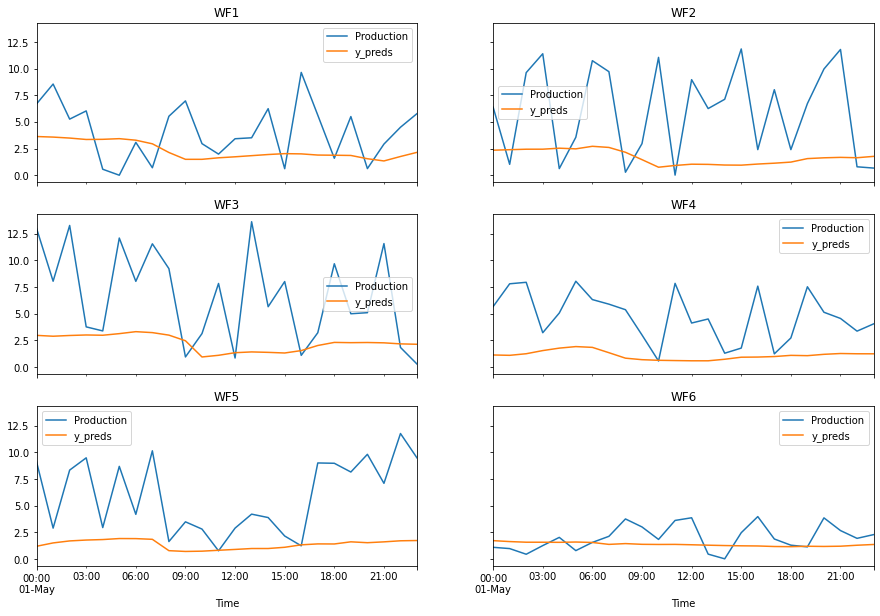

In [ ]:
wf_ls =['WF1','WF2','WF3','WF4','WF5','WF6']
i=1
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(15,10))
axes_list = [item for sublist in axes for item in sublist] 
for wf in wf_ls:
  ax = axes_list.pop(0)
  y_true_wf1=y_true[y_true['WF']==wf]
  ax1=y_true_wf1.plot('Time','Production',ax=ax)
  y_preds_wf1=y_preds[y_preds['WF']==wf]
  y_preds_wf1.plot('Time','y_preds',ax=ax1)
  ax.set_title(wf)
plt.show()

#FB Prophet

In [ ]:
from fbprophet import Prophet

In [ ]:
def prophet_convert(wf_train_h):
  wf_train_h['ds']=wf_train_h.index
  wf_train_h['y']=wf_train_h['Production']
  return wf_train_h

In [ ]:
wf1_train_00h= prophet_convert(wf1_train_00h)
wf2_train_00h= prophet_convert(wf2_train_00h)
wf3_train_00h= prophet_convert(wf3_train_00h)
wf4_train_00h= prophet_convert(wf4_train_00h)
wf5_train_00h= prophet_convert(wf5_train_00h)
wf6_train_00h= prophet_convert(wf6_train_00h)

In [ ]:
import itertools

In [ ]:
def rmse(df,forecast):
  rmse = np.mean((df['y'].values - forecast['yhat'].tail(24).values)**2)
  return rmse

In [ ]:
def prophet_model(df):
  param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
  }

  # Generate all combinations of parameters
  all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
  newape = []
  k=0  # Store the RMSEs for each params here
  for params in all_params:
    m = Prophet(**params,yearly_seasonality=False)
    m.add_regressor('NWP1_00h_D-1_speed')
    m.add_regressor('NWP1_00h_D-1_dir')
    m.add_regressor('NWP1_00h_D-1_T')
    m.fit(df[df['ds']<pd.Timestamp(2019,5,1)])
    future = m.make_future_dataframe(periods=24,freq='H')
    future['NWP1_00h_D-1_speed']=df['NWP1_00h_D-1_speed'].values
    future['NWP1_00h_D-1_dir']=df['NWP1_00h_D-1_dir'].values
    future['NWP1_00h_D-1_T']=df['NWP1_00h_D-1_T'].values
    forecast = m.predict(future)
    
    out=df[df['ds']>=pd.Timestamp(2019,5,1)]
    ape=rmse(out,forecast)
    print(ape)
    if len(newape)==0:
      wf_forecast = forecast
      newparams = params      
      newape.append(ape)
      k=ape
    elif ape<k:
      wf_forecast = forecast
      newparams = params      
      k=ape
  #fig2 = m.plot_components(forecast)
  return wf_forecast,newparams

In [ ]:
wf1_forecast,wf1params = prophet_model(wf1_train_00h)
wf2_forecast,wf2params = prophet_model(wf2_train_00h)
wf3_forecast,wf3params = prophet_model(wf3_train_00h)
wf4_forecast,wf4params = prophet_model(wf4_train_00h)
wf5_forecast,wf5params = prophet_model(wf5_train_00h)
wf6_forecast,wf6params = prophet_model(wf6_train_00h)


In [ ]:
wf_all_preds_prophet=np.concatenate([wf1_forecast['yhat'].tail(24).values,wf2_forecast['yhat'].tail(24).values,wf3_forecast['yhat'].tail(24).values,wf4_forecast['yhat'].tail(24).values,wf5_forecast['yhat'].tail(24).values,wf6_forecast['yhat'].tail(24).values])

In [ ]:
cape=CAPE_CNR_function(Y_test_nextday, wf_all_preds_prophet)
cape

53.702086016964685

In [ ]:
all_preds_prop=pd.DataFrame(wf_all_preds_prophet,columns=['y_preds'])
all_preds_prop.reset_index(inplace=True)
all_preds_prop=all_preds_prop.drop('index',axis=1)
y_preds=pd.concat([test_aug['Time'],test_aug['WF'],all_preds_prop],axis=1)
y_preds=y_preds.set_index(y_preds['Time'])

In [ ]:
y_true=y_true.set_index(y_true['Time'])
y_preds=y_preds.set_index(y_preds['Time'])

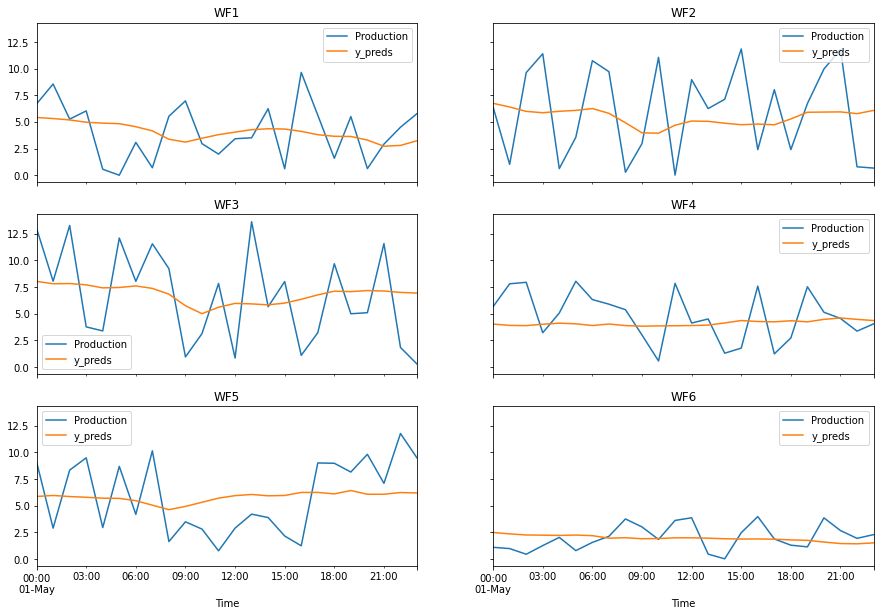

In [ ]:
wf_ls =['WF1','WF2','WF3','WF4','WF5','WF6']
i=1
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(15,10))
axes_list = [item for sublist in axes for item in sublist] 
for wf in wf_ls:
  ax = axes_list.pop(0)
  y_true_wf1=y_true[y_true['WF']==wf]
  ax1=y_true_wf1.plot('Time','Production',ax=ax)
  y_preds_wf1=y_preds[y_preds['WF']==wf]
  y_preds_wf1.plot('Time','y_preds',ax=ax1)
  ax.set_title(wf)
plt.show()
#y_true

In [ ]:
wf1_forecast=wf1_forecast.set_index(wf1_forecast['ds'])

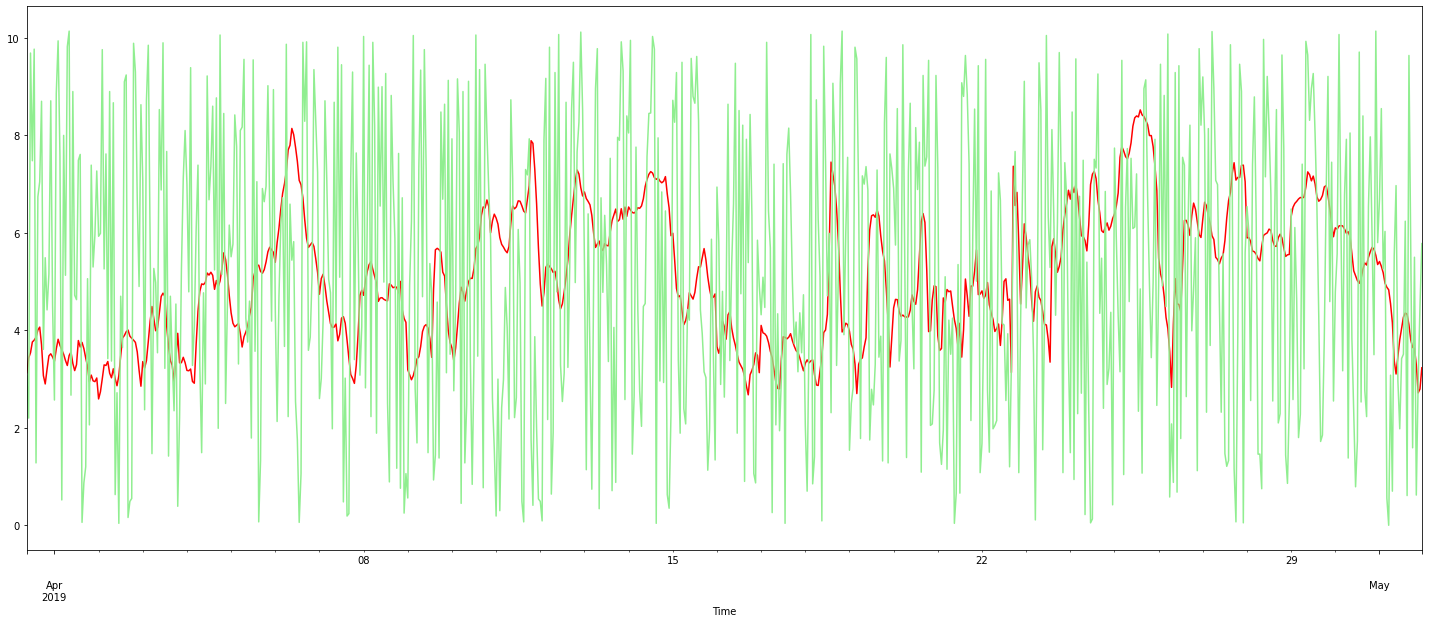

In [ ]:
plt.subplots(figsize=(25,10))
wf1_forecast['yhat'][8000:].plot(color='r')
wf1_train_00h['y'][8000:].plot(color='lightgreen')

## Neural Nets

In [ ]:
import tensorflow as tf


In [ ]:
def train_test(train,test):
  train_X= train.loc[:,['hour', 'day', 'month', 'week', 'NWP1_00h_D-1_speed',
        'NWP1_00h_D-1_dir', 'NWP1_00h_D-1_T',
        'NWP1_12h_D-2_speed', 'NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T']]
  train_y=train['Production']
  test_X = test.loc[:,['hour', 'day', 'month', 'week', 'NWP1_00h_D-1_speed',
        'NWP1_00h_D-1_dir', 'NWP1_00h_D-1_T',
        'NWP1_12h_D-2_speed', 'NWP1_12h_D-2_dir', 'NWP1_12h_D-2_T']]
  test_y=test['Production']
  return train_X.values,train_y.values,test_X.values,test_y.values

In [ ]:
train_X,train_y,test_X,test_y=train_test(wf1_train_2d,wf1_test_2d)

In [ ]:
train_X.shape[0],train_X.shape[1]

(8759, 10)

In [ ]:

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8759, 1, 10) (8759,) (6190, 1, 10) (6190,)


In [ ]:
def model_lstm(train_X,train_y,test_X,test_y): 
  lstm_model = tf.keras.models.Sequential([
      # Shape [batch, time, features] => [batch, time, lstm_units]
      tf.keras.layers.LSTM(128, return_sequences=True),
      # Shape => [batch, time, features]
      tf.keras.layers.Dense(units=1)
  ])

  lstm_model.compile(loss='mae', optimizer='adam')

  history = lstm_model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

  return history,lstm_model

In [ ]:
history,modellstm=model_lstm(train_X,train_y,test_X,test_y)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
def model_cnn(train_X,train_y,test_X,test_y): 
  cnn_model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                      activation="relu",batch_size=32,
                      input_shape=[train_X.shape[0], train_X.shape[1]]),
      # Shape [batch, time, features] => [batch, time, lstm_units]
      #tf.keras.layers.LSTM(128, return_sequences=True),
      # Shape => [batch, time, features]
      tf.keras.layers.MaxPooling1D(pool_size=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.Dense(1)
  ])
  print(cnn_model.summary())
  cnn_model.compile(loss='mae', optimizer='adam')

  history = cnn_model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

  return history,cnn_model

In [ ]:
history,modelcnn=model_cnn(train_X,train_y,test_X,test_y)

ValueError: ignored

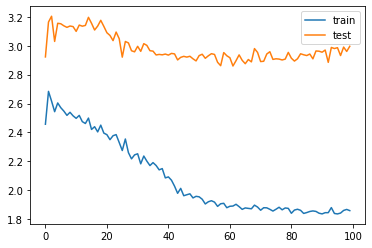

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
yhat = lstm_model.predict(test_X)

In [ ]:
test_y

array([1.34, 7.28, 5.74, ..., 7.71, 2.74, 0.78])

In [ ]:
CAPE_CNR_function(test_y,yhat)

360465.5031389815